In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.3 MB/s eta 0:00:00:00:0100:01


In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import random
import rasterio

## A. EDA

### 1️⃣ Đường dẫn dataset


In [10]:
BASE_DIR = "/kaggle/input/global-land-cover-mapping-openearthmap"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
LABEL_DIR = os.path.join(BASE_DIR, "label")

### 2️⃣ Định nghĩa class & màu 


In [11]:
CLASS_INFO = {
    "Bareland":       "#800000",
    "Rangeland":      "#00FF24",
    "Developed space":"#949494",
    "Road":           "#FFFFFF",
    "Tree":           "#226126",
    "Water":          "#0045FF",
    "Agriculture land":"#4BB549",
    "Building":       "#DE1F07"
}

In [12]:
CLASS_COLORS = {k: tuple(int(v.lstrip("#")[i:i+2], 16) for i in (0, 2, 4)) for k, v in CLASS_INFO.items()}
CLASS_NAMES = list(CLASS_INFO.keys())
N_CLASSES = len(CLASS_INFO)

### 3️⃣ Thống kê số file trong từng tập


In [13]:
def count_files(dir_path):
    total = 0
    for root, _, files in os.walk(dir_path):
        total += len([f for f in files if f.endswith(".tif")])
    return total

In [14]:
dataset_summary = {
    "train_images": count_files(os.path.join(IMAGE_DIR, "train")),
    "val_images": count_files(os.path.join(IMAGE_DIR, "val")),
    "test_images": count_files(os.path.join(IMAGE_DIR, "test")),
    "train_labels": count_files(os.path.join(LABEL_DIR, "train")),
    "val_labels": count_files(os.path.join(LABEL_DIR, "val")),
}
print("📁 Dataset summary:")
for k, v in dataset_summary.items():
    print(f"  {k}: {v}")

📁 Dataset summary:
  train_images: 2303
  val_images: 384
  test_images: 1151
  train_labels: 2303
  val_labels: 384


### 4️⃣ Kiểm tra kích thước & số kênh toàn bộ ảnh


In [15]:
from collections import Counter


In [16]:
def get_image_shapes(dir_path):
    shapes = []
    for root, _, files in os.walk(dir_path):
        for f in tqdm(files, desc=f"Checking {os.path.basename(root)}"):
            if f.endswith(".tif"):
                img = Image.open(os.path.join(root, f))
                arr = np.array(img)
                if arr.ndim == 2:
                    shape = (arr.shape[0], arr.shape[1], 1)
                else:
                    shape = arr.shape
                shapes.append(shape)
    return shapes

In [29]:
train_shapes = get_image_shapes(os.path.join(IMAGE_DIR, "train"))
val_shapes = get_image_shapes(os.path.join(IMAGE_DIR, "val"))
test_shapes = get_image_shapes(os.path.join(IMAGE_DIR, "test"))
train_label_shapes = get_image_shapes(os.path.join(LABEL_DIR, "train"))
val_label_shapes = get_image_shapes(os.path.join(LABEL_DIR, "val"))


Checking val: 100%|██████████| 384/384 [00:04<00:00, 80.82it/s]


In [30]:
def print_shape_summary(name, shape_list):
    shape_counts = Counter(shape_list)
    print(f"\n📂 {name} — unique shapes:")
    for shape, count in shape_counts.items():
        print(f"  {shape}: {count} files")
    total = sum(shape_counts.values())
    print(f"  → Total: {total} files")

In [32]:
print_shape_summary("Train Images", train_shapes)
print_shape_summary("Val Images", val_shapes)
print_shape_summary("Test Images", test_shapes)
print_shape_summary("Train Labels", train_label_shapes)
print_shape_summary("Val Labels", val_label_shapes)



📂 Train Images — unique shapes:
  (1024, 1024, 3): 1649 files
  (650, 650, 3): 156 files
  (1000, 1000, 3): 426 files
  (406, 439, 3): 19 files
  (900, 900, 3): 30 files
  (406, 438, 3): 23 files
  → Total: 2303 files

📂 Val Images — unique shapes:
  (1024, 1024, 3): 275 files
  (650, 650, 3): 26 files
  (1000, 1000, 3): 71 files
  (900, 900, 3): 5 files
  (406, 438, 3): 2 files
  (406, 439, 3): 5 files
  → Total: 384 files

📂 Test Images — unique shapes:
  (1024, 1024, 3): 823 files
  (1000, 1000, 3): 213 files
  (650, 650, 3): 78 files
  (407, 439, 3): 1 files
  (406, 438, 3): 9 files
  (406, 439, 3): 11 files
  (900, 900, 3): 15 files
  (1024, 958, 3): 1 files
  → Total: 1151 files

📂 Train Labels — unique shapes:
  (1024, 1024, 1): 1649 files
  (650, 650, 1): 156 files
  (1000, 1000, 1): 426 files
  (406, 439, 1): 19 files
  (900, 900, 1): 30 files
  (406, 438, 1): 23 files
  → Total: 2303 files

📂 Val Labels — unique shapes:
  (1024, 1024, 1): 275 files
  (650, 650, 1): 26 files


### 5️⃣ Kiểm tra phân bố pixel mask theo class


In [38]:
def analyze_all_label_values(label_dir):
    all_values = set()
    min_val, max_val = float('inf'), float('-inf')
    
    print(f"📂 Scanning all label files in: {label_dir}")
    files = [f for f in os.listdir(label_dir) if f.endswith(".tif")]
    for file in tqdm(files, desc="Analyzing label values"):
        path = os.path.join(label_dir, file)
        with rasterio.open(path) as src:
            label = src.read(1)
            unique_vals = np.unique(label)
            all_values.update(unique_vals)
            min_val = min(min_val, unique_vals.min())
            max_val = max(max_val, unique_vals.max())

    print("\n📊 Summary of all label values:")
    print(f"🔢 Unique class IDs in dataset: {sorted(all_values)}")
    print(f"📉 Min value: {min_val}, 📈 Max value: {max_val}")
    print(f"🗂️ Total label files scanned: {len(files)}")


In [39]:
analyze_all_label_values(os.path.join(LABEL_DIR, "train"))


📂 Scanning all label files in: /kaggle/input/global-land-cover-mapping-openearthmap/label/train


Analyzing label values: 100%|██████████| 2303/2303 [01:12<00:00, 31.85it/s]


📊 Summary of all label values:
🔢 Unique class IDs in dataset: [0, 1, 2, 3, 4, 5, 6, 7, 8]
📉 Min value: 0, 📈 Max value: 8
🗂️ Total label files scanned: 2303


In [48]:
CLASS_LABELS = {
    0: "Background",
    1: "Bareland",
    2: "Rangeland",
    3: "Developed space",
    4: "Road",
    5: "Tree",
    6: "Water",
    7: "Agriculture land",
    8: "Building",
}

In [50]:
def compute_label_distribution(label_dir):
    class_counts = Counter()
    total_pixels = 0

    files = [f for f in os.listdir(label_dir) if f.endswith(".tif")]
    for file in tqdm(files, desc=f"Counting {os.path.basename(label_dir)}"):
        path = os.path.join(label_dir, file)
        with rasterio.open(path) as src:
            label = src.read(1)
            unique, counts = np.unique(label, return_counts=True)
            for u, c in zip(unique, counts):
                class_counts[int(u)] += c
            total_pixels += label.size

    # Chuyển sang phần trăm %
    distribution = {cls: (class_counts.get(cls, 0) / total_pixels * 100)
                    for cls in CLASS_LABELS.keys()}

    return distribution

In [51]:
train_dist = compute_label_distribution(os.path.join(LABEL_DIR, "train"))
val_dist = compute_label_distribution(os.path.join(LABEL_DIR, "val"))

Counting val: 100%|██████████| 384/384 [00:07<00:00, 51.42it/s]


In [52]:
def print_distribution(dist, title):
    print(f"\n📊 {title}")
    for cls, name in CLASS_LABELS.items():
        print(f"  {cls:<2} ({name:<17}): {dist[cls]:6.3f}%")

print_distribution(train_dist, "Train Label Distribution")
print_distribution(val_dist, "Validation Label Distribution")



📊 Train Label Distribution
  0  (Background       ):  0.703%
  1  (Bareland         ):  1.830%
  2  (Rangeland        ): 20.887%
  3  (Developed space  ): 18.594%
  4  (Road             ):  6.693%
  5  (Tree             ): 18.349%
  6  (Water            ):  3.215%
  7  (Agriculture land ): 12.649%
  8  (Building         ): 17.080%

📊 Validation Label Distribution
  0  (Background       ):  0.842%
  1  (Bareland         ):  1.280%
  2  (Rangeland        ): 20.877%
  3  (Developed space  ): 19.642%
  4  (Road             ):  7.004%
  5  (Tree             ): 18.631%
  6  (Water            ):  2.341%
  7  (Agriculture land ): 11.726%
  8  (Building         ): 17.657%


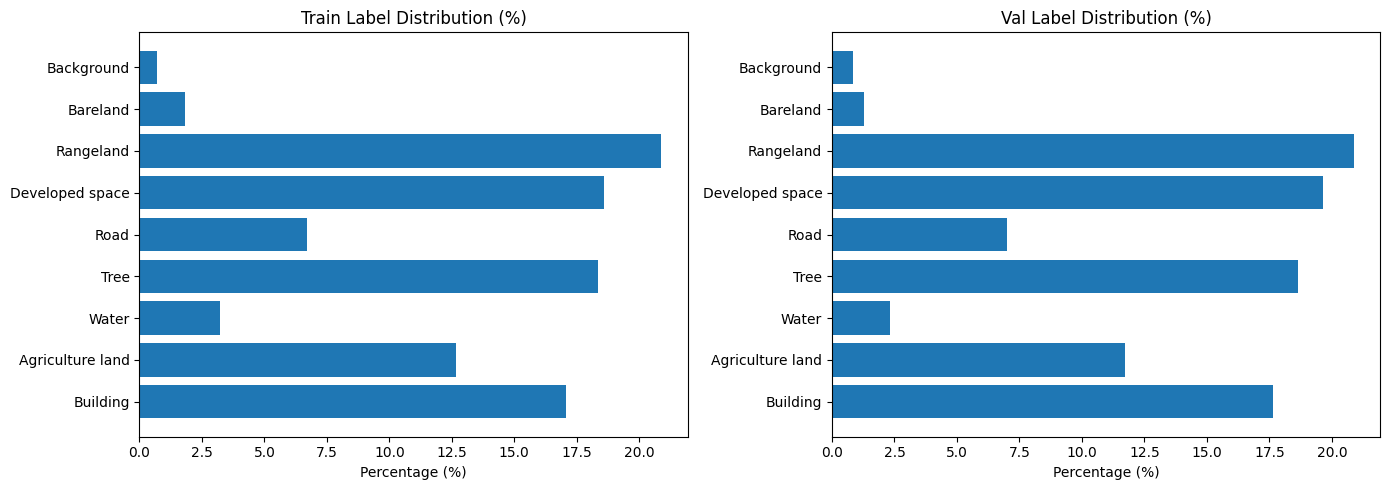

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
for i, (dist, name) in enumerate(zip([train_dist, val_dist], ["Train", "Val"])):
    names = [CLASS_LABELS[k] for k in CLASS_LABELS.keys()]
    values = [dist[k] for k in CLASS_LABELS.keys()]
    ax[i].barh(names, values)
    ax[i].set_title(f"{name} Label Distribution (%)")
    ax[i].set_xlabel("Percentage (%)")
    ax[i].invert_yaxis()
plt.tight_layout()
plt.show()

### 6️⃣ Visualize một vài ảnh và mask tương ứng


In [67]:
from matplotlib.colors import ListedColormap, BoundaryNorm


In [68]:
CLASS_COLORS_HEX = {
    0: "#000000",   # Background (giả định)
    1: "#800000",   # Bareland
    2: "#00FF24",   # Rangeland
    3: "#949494",   # Developed space
    4: "#FFFFFF",   # Road
    5: "#226126",   # Tree
    6: "#0045FF",   # Water
    7: "#4BB549",   # Agriculture land
    8: "#DE1F07",   # Building
}

CLASS_NAMES = [
    "Background",
    "Bareland",
    "Rangeland",
    "Developed space",
    "Road",
    "Tree",
    "Water",
    "Agriculture land",
    "Building",
]

949494

In [69]:
cmap = ListedColormap([CLASS_COLORS_HEX[i] for i in range(len(CLASS_NAMES))])
norm = BoundaryNorm(np.arange(-0.5, len(CLASS_NAMES) + 0.5), cmap.N)

In [70]:
train_img_dir = "/kaggle/input/global-land-cover-mapping-openearthmap/images/train"
train_label_dir = "/kaggle/input/global-land-cover-mapping-openearthmap/label/train"

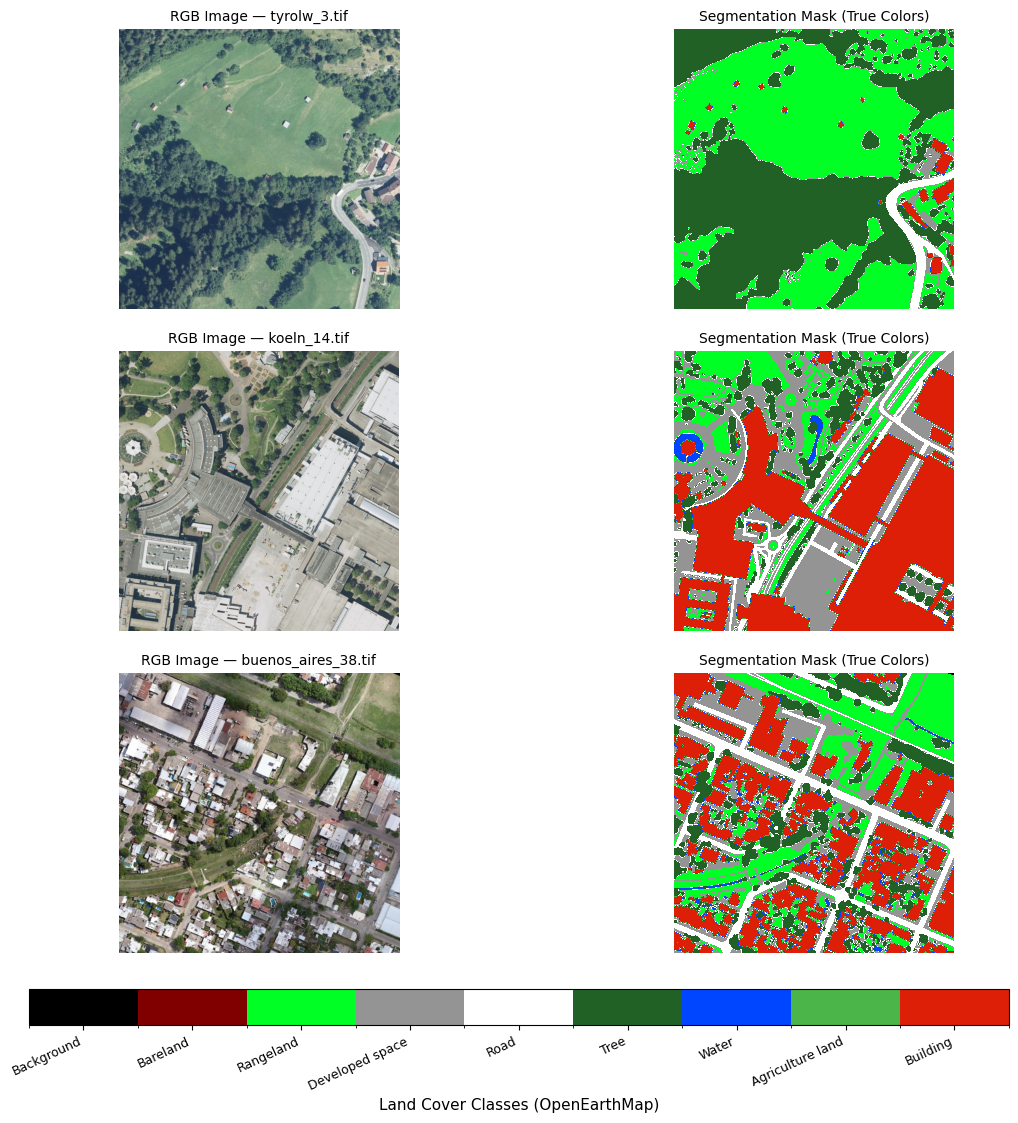

In [72]:
sample_files = random.sample(os.listdir(train_img_dir), 3)

fig, axes = plt.subplots(len(sample_files), 2, figsize=(14, 12))
fig.subplots_adjust(wspace=0.05, hspace=0.15)  # khoảng cách giữa các subplot

for i, fname in enumerate(sample_files):
    # Đọc ảnh RGB
    with rasterio.open(os.path.join(train_img_dir, fname)) as src:
        img = src.read().transpose(1, 2, 0)

    # Đọc mask
    with rasterio.open(os.path.join(train_label_dir, fname)) as src:
        mask = src.read(1)

    # Ảnh RGB
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"RGB Image — {fname}", fontsize=10)
    axes[i, 0].axis("off")

    # Mask
    im = axes[i, 1].imshow(mask, cmap=cmap, norm=norm)
    axes[i, 1].set_title("Segmentation Mask (True Colors)", fontsize=10)
    axes[i, 1].axis("off")

# === Thêm colorbar bên dưới toàn bộ figure ===
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal", ticks=np.arange(len(CLASS_NAMES)))
cbar.ax.set_xticklabels(CLASS_NAMES, rotation=25, ha="right", fontsize=9)
cbar.set_label("Land Cover Classes (OpenEarthMap)", fontsize=11)

plt.show()

#### Tổng kết Phân tích Dữ liệu Khám phá (EDA) - OpenEarthMap

Đây là những phát hiện then chốt và các quyết định cần thực hiện dựa trên phân tích bộ dữ liệu.
##### 1. Cấu trúc & Tính toàn vẹn Dữ liệu

    File train.txt có 2303 cặp ảnh/nhãn hợp lệ và tồn tại trong thư mục.


##### 2. Đặc điểm Ảnh đầu vào (Images)

    Định dạng: Ảnh RGB 3 kênh, định dạng .tif.

    Kích thước không đồng nhất: Các ảnh có kích thước khác nhau 1024x1024, 1000x1000, ...

        Hành động: Bắt buộc phải thực hiện bước tiền xử lý để resize tất cả ảnh và mask về một kích thước chuẩn (ví dụ: 512x512) trước khi đưa vào mô hình.

##### 3. Đặc điểm Nhãn (Masks) - Phát hiện quan trọng nhất

    Bản chất của Mask: Mask KHÔNG phải là ảnh màu RGB. Chúng là ảnh 1 kênh, trong đó mỗi giá trị pixel là một số nguyên đại diện cho ID của lớp (0, 1, 2, ..., 8). Với 0 phỏng đoán là lớp nền từ 1->8 là theo Mapping màu theo README

        Hành động: Pipeline dữ liệu sẽ rất đơn giản, chỉ cần đọc kênh đầu tiên của file mask là có ngay nhãn. Không cần bất kỳ thuật toán chuyển đổi màu sắc nào.


##### 4. Phân bố các lớp & Mất cân bằng Dữ liệu

    Mất cân bằng nghiêm trọng: Dữ liệu cực kỳ mất cân bằng.

    Hành động:

        Hàm mất mát (Loss Function): Không nên dùng Cross-Entropy thông thường. Cần sử dụng các hàm loss chuyên dụng cho segmentation và dữ liệu mất cân bằng như Focal Loss, Dice Loss, hoặc Weighted Cross-Entropy.

        Chỉ số đánh giá (Metric): Không dùng Accuracy. Chỉ số chính để theo dõi phải là Mean Intersection over Union (mIoU).